# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Unsupervised Model

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100, 50, 50]
layers_dec_dim = [50, 50, 100]
layers_dis_dim = [50, 50, 100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim,
             layers_dec_dim=layers_dec_dim,
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
batch_size                      35                                batch size
epochs                          50                          number of epochs
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l1_weight                     0.01      weight of l1 activity regularization
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
lr_ae                       0.0002              learning rate of autoencoder
dr_ae                        1e-06                 decay rate of autoencoder
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
lr_dis                      0.0001            learning rate of discriminator
dr_dis                       1e-06               decay rate of discriminator
lr_gen                      0.0001                learning rate of generator
dr_gen                       1e-06                   decay rate of generator

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


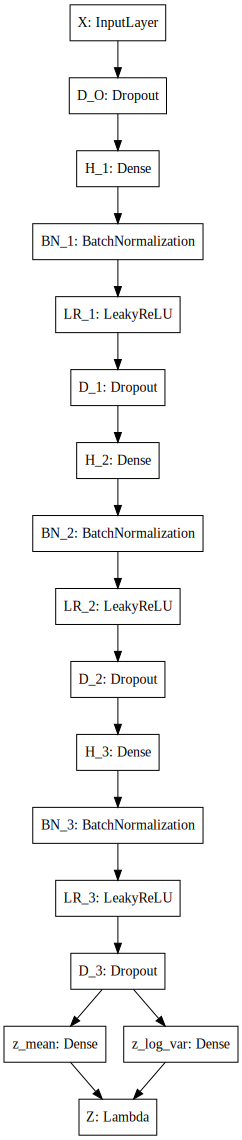

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


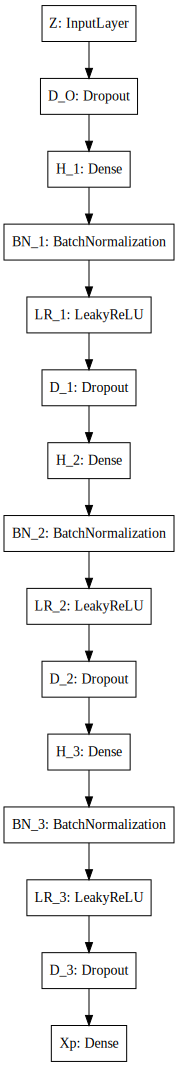

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


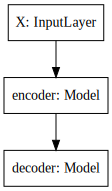

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


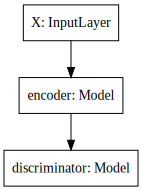

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


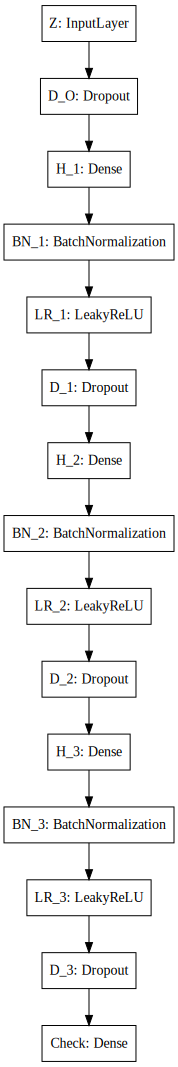

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.055328, generation loss: 0.372084, discriminator loss: 0.288449


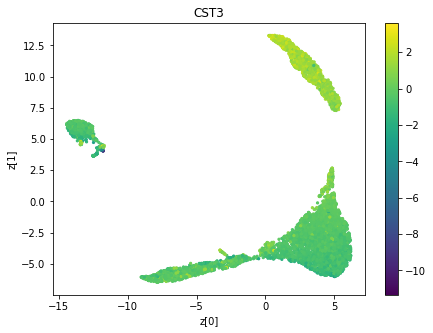

Training completed.


In [12]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [13]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC10k', exist_ok=True)
model.export_model('../models/AAE1/PBMC10k')

All networks exported in h5 format.


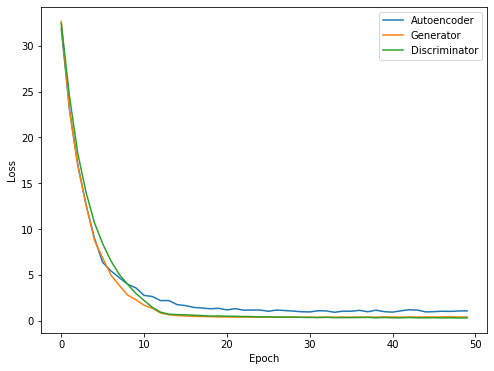

In [14]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

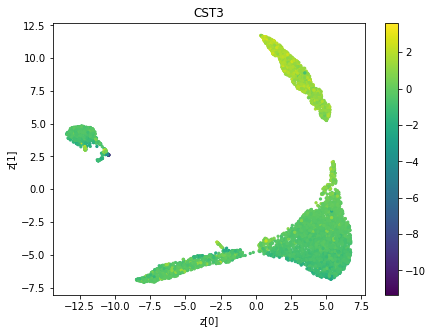

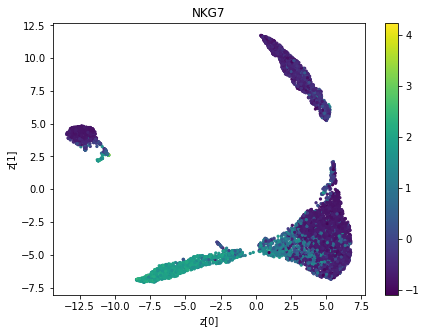

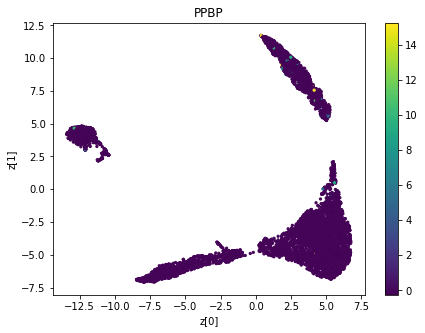

In [16]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=False)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [8]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [10]:
model = AAE2(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [8]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


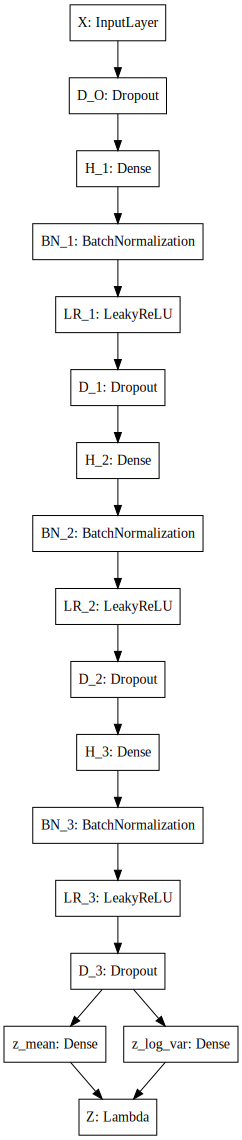

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


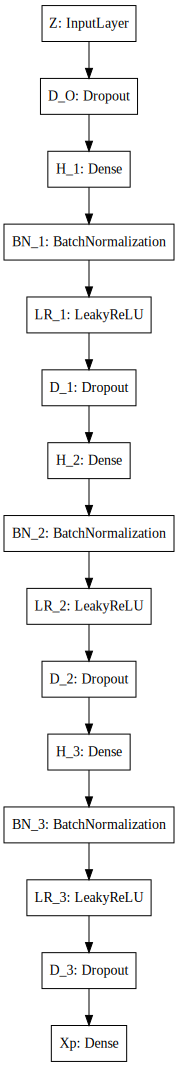

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


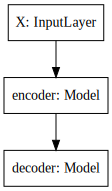

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


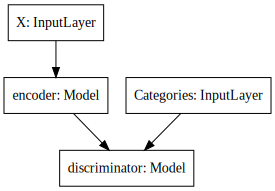

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


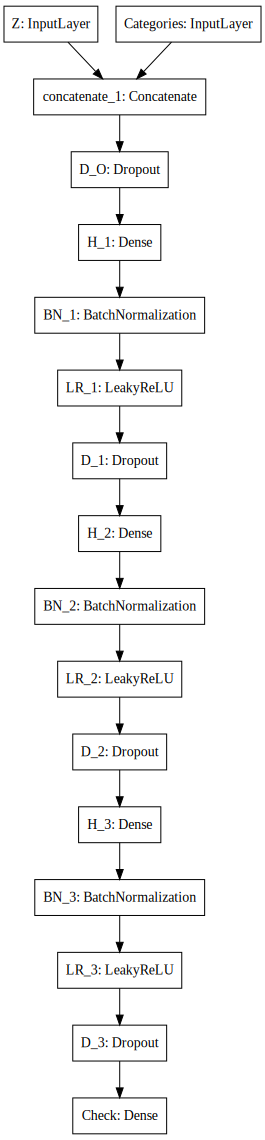

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 0.969549, generation loss: 0.375600, discriminator loss: 0.294835


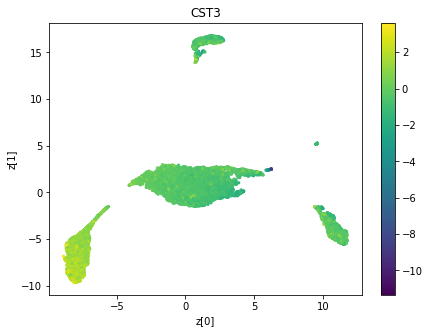

Training completed.


In [9]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [ ]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC10k', exist_ok=True)
model.export_model('../models/AAE2/PBMC10k')

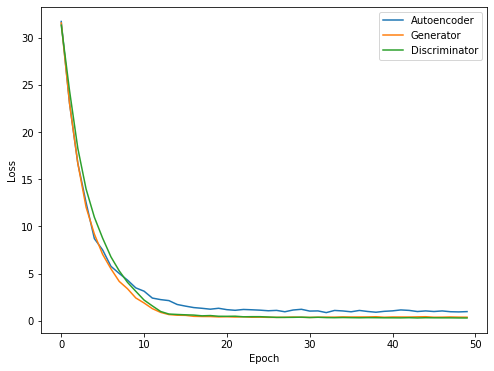

In [10]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

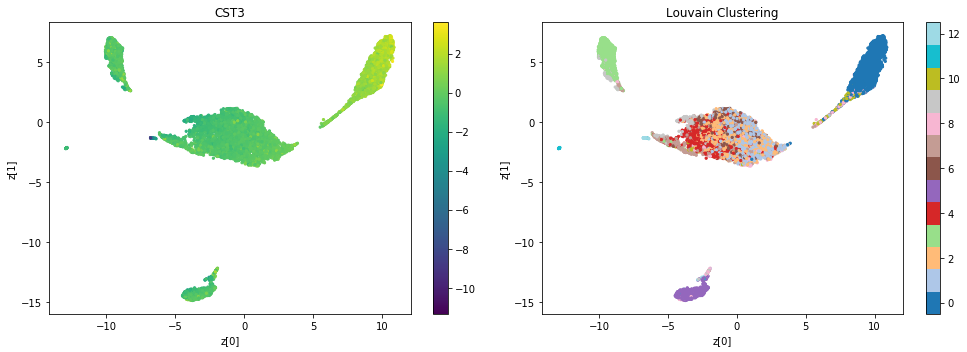

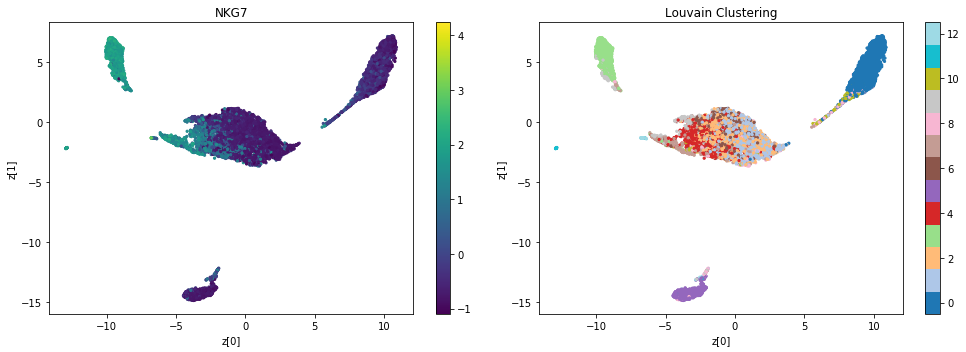

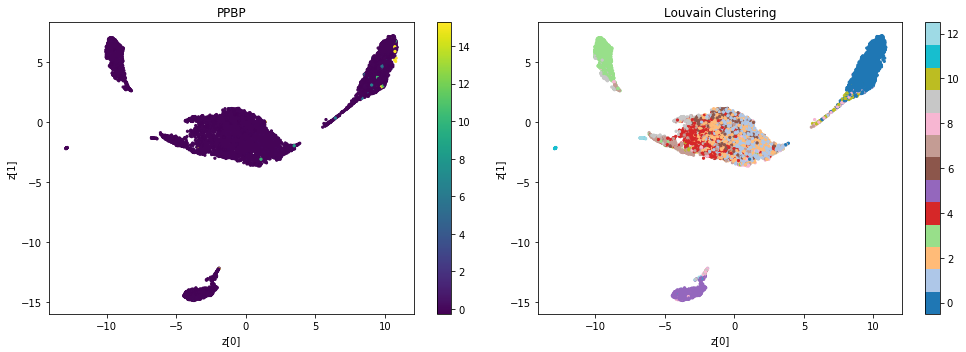

In [11]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Supervised Adversarial Autoencoder

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE3(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
batch_size                      35                                batch size
epochs                          50                          number of epochs
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l1_weight                     0.01      weight of l1 activity regularization
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
lr_ae                       0.0002              learning rate of autoencoder
dr_ae                        1e-06                 decay rate of autoencoder
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
lr_dis                      0.0001            learning rate of discriminator
dr_dis                       1e-06               decay rate of discriminator
lr_gen                      0.0001                learning rate of generator
dr_gen                       1e-06                   decay rate of generator

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE3/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE3/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


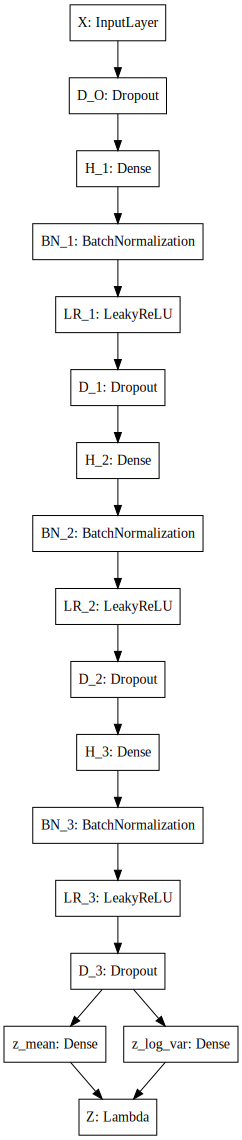

In [10]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


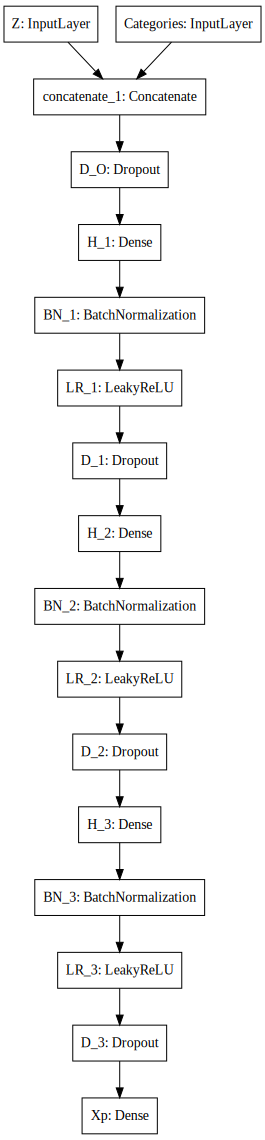

In [11]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


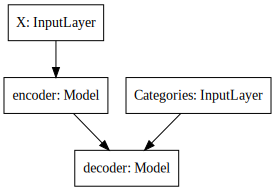

In [12]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


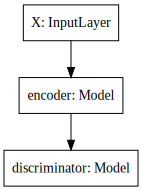

In [13]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


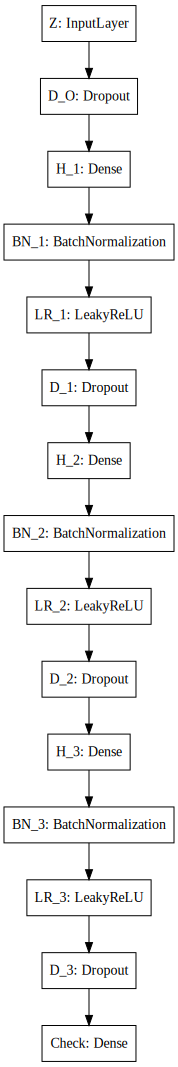

In [14]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 0.945701, generation loss: 0.369915, discriminator loss: 0.297389


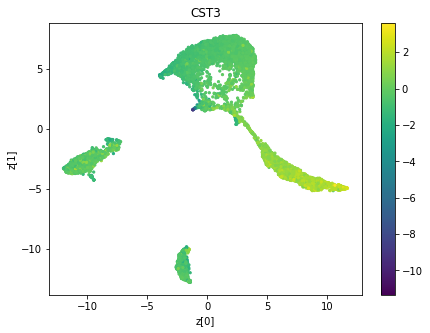

Training completed.


In [10]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [11]:
# save models in h5 format
os.makedirs('../models/AAE3/PBMC10k', exist_ok=True)
model.export_model('../models/AAE3/PBMC10k')

All networks exported in h5 format.


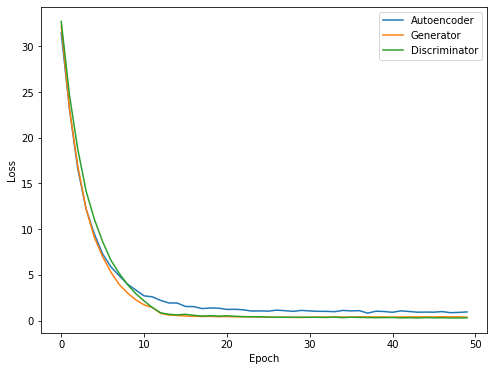

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

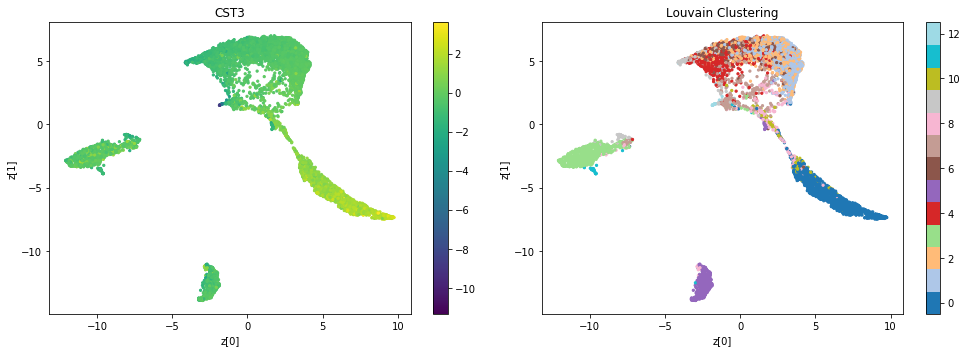

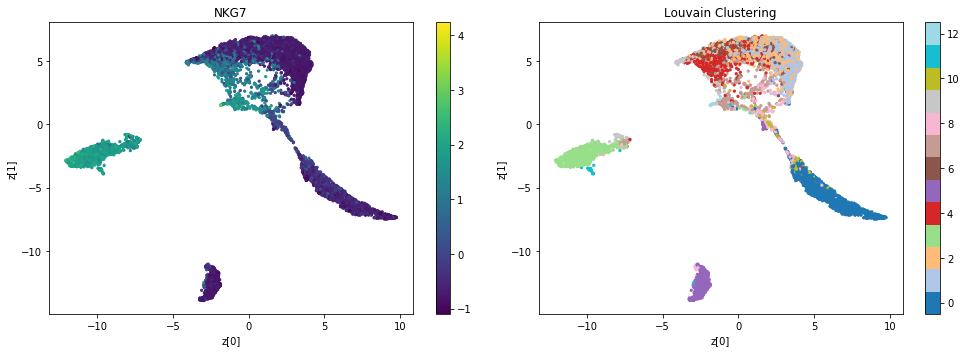

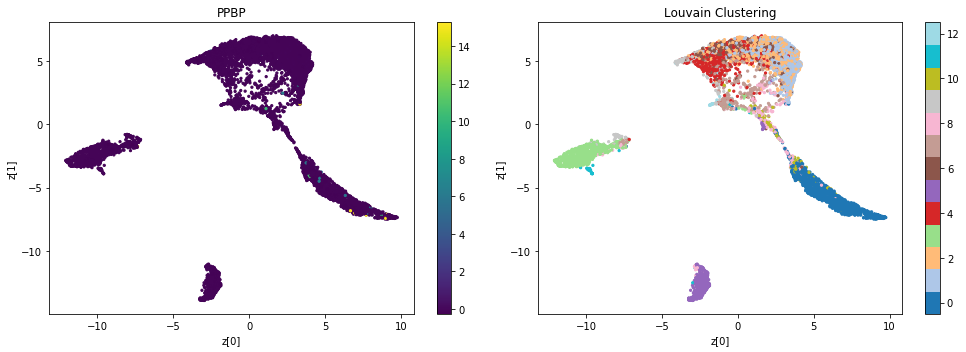

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Semi-supervised Adversarial Autoencoder

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 30, LATENT_DIM]
LAYERS_DEC_DIM = [30, 30, 40, 50, 50, 100, 200]
LAYERS_DIS_DIM = [20, 20, 30, 40, 50, 50, 100, 200]
LAYERS_DIS_CAT_DIM = [20, 20, 30, 40, 50, 50, 100]

BATCH_SIZE = 35
EPOCHS = 100
TEMPERATURE = 0.01

In [5]:
model = AAE4(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM,
             layers_dec_dim=LAYERS_DEC_DIM,
             layers_dis_dim=LAYERS_DIS_DIM,
             layers_dis_cat_dim=LAYERS_DIS_CAT_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             tau=TEMPERATURE)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value  \
batch_size                       35   
epochs                          100   
alpha                           0.1   
do_rate                         0.1   
kernel_initializer   glorot_uniform   
bias_initializer              zeros   
l2_weight                      0.01   
l1_weight                      0.01   
latent_dim                       10   
layer_1_enc_dim                 200   
layer_2_enc_dim                 100   
layer_3_enc_dim                  50   
layer_4_enc_dim                  50   
layer_5_enc_dim                  40   
layer_6_enc_dim                  30   
layer_7_enc_dim                  30   
layer_8_enc_dim                  10   
layer_1_dec_dim                  30   
layer_2_dec_dim                  30   
layer_3_dec_dim                  40   
layer_4_dec_dim                  50   
layer_5_dec_dim                  50   
layer_6_dec_dim                 100   
layer_7_dec_dim                 200   
lr_ae                        0.0002   
dr_ae                         1e-06   
layer_1_dis_dim                  20   
layer_2_dis_dim                  20   
layer_3_dis_dim                  30   
layer_4_dis_dim                  40   
layer_5_dis_dim                  50   
layer_6_dis_dim                  50   
layer_7_dis_dim                 100   
layer_8_dis_dim                 200   
lr_dis                       0.0001   
dr_dis                        1e-06   
lr_gen                       0.0001   
dr_gen                        1e-06   
layer_1_dis_cat_dim            20.0   
layer_2_dis_cat_dim            20.0   
layer_3_dis_cat_dim            30.0   
layer_4_dis_cat_dim            40.0   
layer_5_dis_cat_dim            50.0   
layer_6_dis_cat_dim            50.0   
layer_7_dis_cat_dim           100.0   
lr_dis_cat                   0.0001   
dr_dis_cat                    1e-06   
tau                            0.01   

                                                       Description  
batch_size                                              batch size  
epochs                                            number of epochs  
alpha                          alpha coeff. in activation function  
do_rate                                               dropout rate  
kernel_initializer          kernel initializer of all dense layers  
bias_initializer              bias initializer of all dense layers  
l2_weight                       weight of l2 kernel regularization  
l1_weight                     weight of l1 activity regularization  
latent_dim                             dimension of latent space Z  
layer_1_enc_dim                 dimension of encoder dense layer 1  
layer_2_enc_dim                 dimension of encoder dense layer 2  
layer_3_enc_dim                 dimension of encoder dense layer 3  
layer_4_enc_dim                 dimension of encoder dense layer 4  
layer_5_enc_dim                 dimension of encoder dense layer 5  
layer_6_enc_dim                 dimension of encoder dense layer 6  
layer_7_enc_dim                 dimension of encoder dense layer 7  
layer_8_enc_dim                 dimension of encoder dense layer 8  
layer_1_dec_dim                 dimension of decoder dense layer 1  
layer_2_dec_dim                 dimension of decoder dense layer 2  
layer_3_dec_dim                 dimension of decoder dense layer 3  
layer_4_dec_dim                 dimension of decoder dense layer 4  
layer_5_dec_dim                 dimension of decoder dense layer 5  
layer_6_dec_dim                 dimension of decoder dense layer 6  
layer_7_dec_dim                 dimension of decoder dense layer 7  
lr_ae                                 learning rate of autoencoder  
dr_ae                                    decay rate of autoencoder  
layer_1_dis_dim           dimension of discriminator dense layer 1  
layer_2_dis_dim           dimension of discriminator dense layer 2  
layer_3_dis_dim           dimension of discriminator dense layer 3  
layer_4_dis_dim           dimension of discrimin

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

Total params: 439,545
Trainable params: 391,083
Non-trainable params: 48,462
__________________________________________________________________________________________________

Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 10)                0         
_________________________________________________________________
D_O (Dropout)                (None, 10)                0         
_________________________________________________________________
H_1 (Dense)                  (None, 20)                200       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 20)                80        
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 20)                0         
_________________________________________________________________
D_1 (Drop

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE4/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE4/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


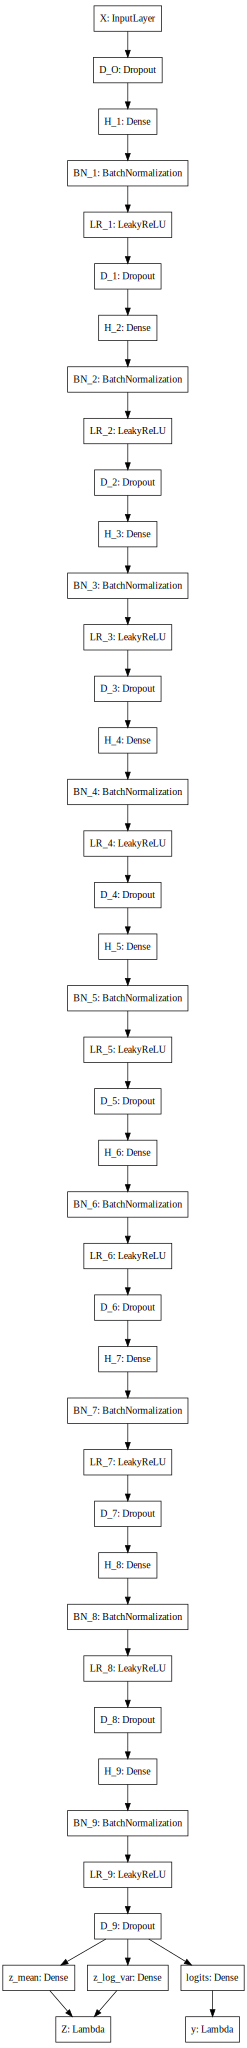

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


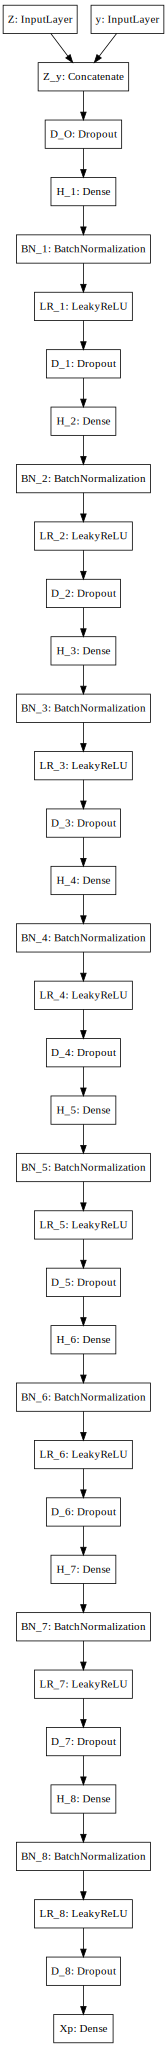

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


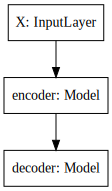

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


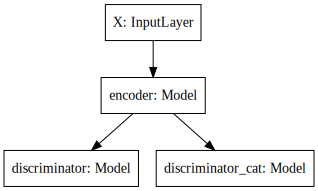

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


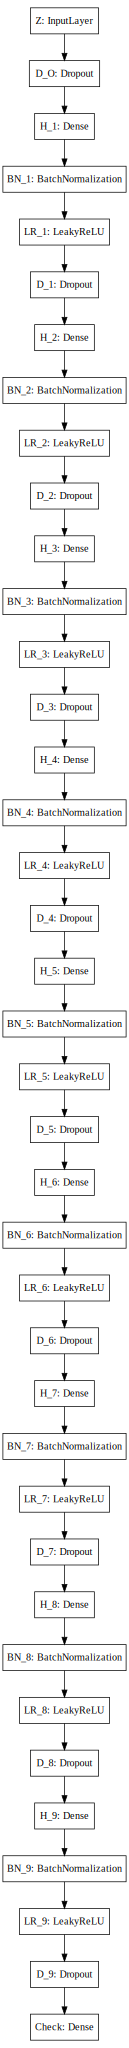

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))


CATEGORICAL DISCRIMINATOR


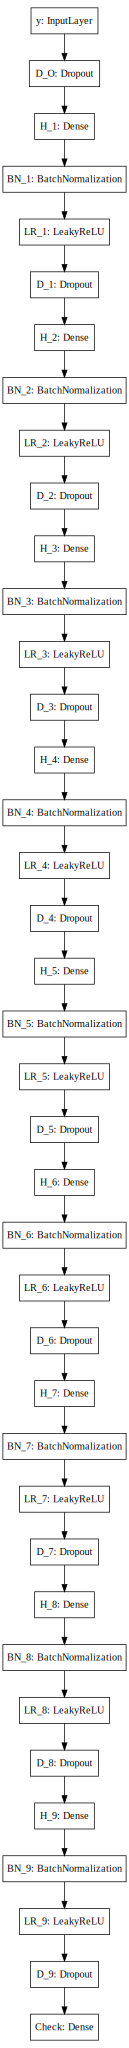

In [17]:
print("\nCATEGORICAL DISCRIMINATOR")
print("=========================")
SVG(model_to_dot(model.discriminator_cat).create(prog='dot', format='svg'))

### Train the model

Epoch 100/100, reconstruction loss: 1.090552, generation loss: 1.387899, discriminator loss: 0.693588, cat. discriminator loss: 0.693106


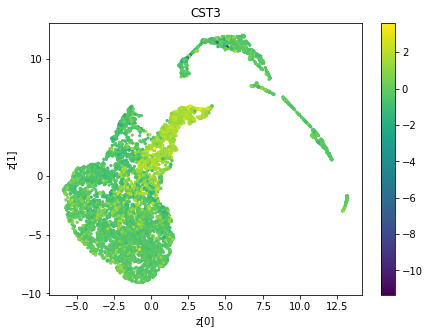

Training completed.


In [12]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss, dis_cat_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE4/PBMC10k', exist_ok=True)
model.export_model('../models/AAE4/PBMC10k')

All networks exported in h5 format.


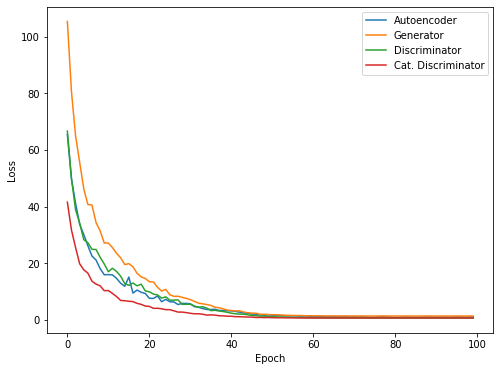

In [17]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.plot(dis_cat_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator', 'Cat. Discriminator'], 
           loc='upper right')
plt.show()

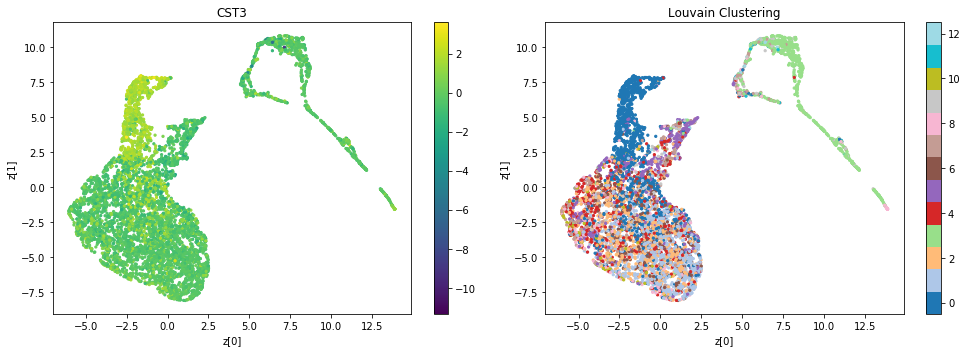

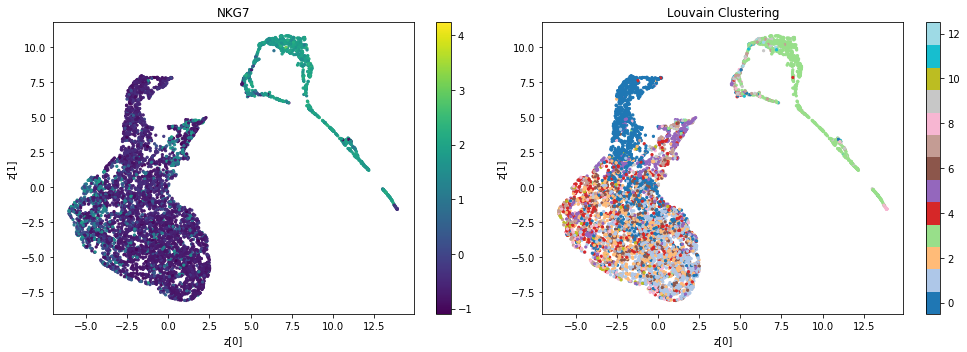

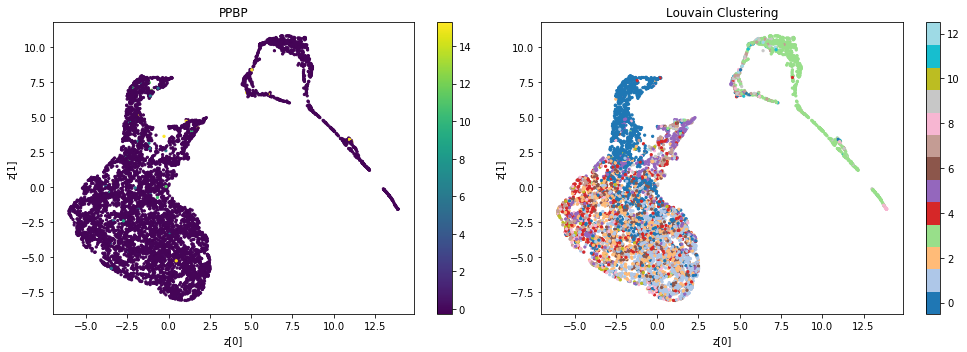

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 30, LATENT_DIM]
LAYERS_DEC_DIM = [LATENT_DIM, 30, 30, 40, 50, 50, 100, 200]

BATCH_SIZE = 35
EPOCHS = 500

In [5]:
model = VAE(latent_dim=LATENT_DIM,
            layers_enc_dim=LAYERS_ENC_DIM,
            layers_dec_dim=LAYERS_DEC_DIM,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                             Description
batch_size                      35                              batch size
epochs                         500                        number of epochs
alpha                          0.1     alpha coeff. in activation function
do_rate                        0.1                            dropout rate
kernel_initializer  glorot_uniform  kernel initializer of all dense layers
bias_initializer             zeros    bias initializer of all dense layers
l2_weight                     0.01      weight of l2 kernel regularization
l1_weight                     0.01    weight of l1 activity regularization
latent_dim                      10             dimension of latent space Z
layer_1_enc_dim                200      dimension of encoder dense layer 1
layer_2_enc_dim                100      dimension of encoder dense layer 2
layer_3_enc_dim                 50      dimension of encoder dense layer 3
layer_4_enc_dim                 50      dimension of encoder dense layer 4
layer_5_enc_dim                 40      dimension of encoder dense layer 5
layer_6_enc_dim                 30      dimension of encoder dense layer 6
layer_7_enc_dim                 30      dimension of encoder dense layer 7
layer_8_enc_dim                 10      dimension of encoder dense layer 8
layer_1_dec_dim                 10      dimension of decoder dense layer 1
layer_2_dec_dim                 30      dimension of decoder dense layer 2
layer_3_dec_dim                 30      dimension of decoder dense layer 3
layer_4_dec_dim                 40      dimension of decoder dense layer 4
layer_5_dec_dim                 50      dimension of decoder dense layer 5
layer_6_dec_dim                 50      dimension of decoder dense layer 6
layer_7_dec_dim                100      dimension of decoder dense layer 7
layer_8_dec_dim                200      dimension of decoder dense layer 8
lr_ae                       0.0002            learning rate of autoencoder
dr_ae                        1e-06               decay rate of autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

X (InputLayer)               (None, 1789)              0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  391960    
_________________________________________________________________
decoder (Model)              (None, 1789)              393629    
Total params: 785,589
Trainable params: 783,549
Non-trainable params: 2,040
_________________________________________________________________


In [11]:
# Export model graphs

os.makedirs('../graphs/VAE/PBMC10k', exist_ok=True)
model.export_graph('../graphs/VAE/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


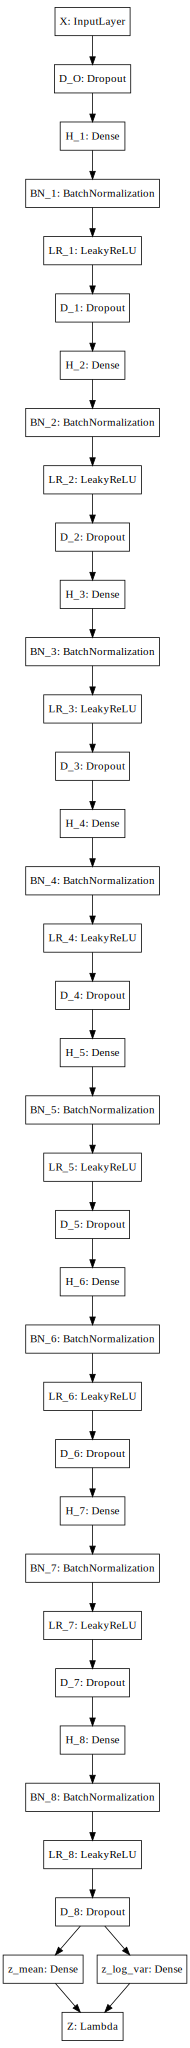

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


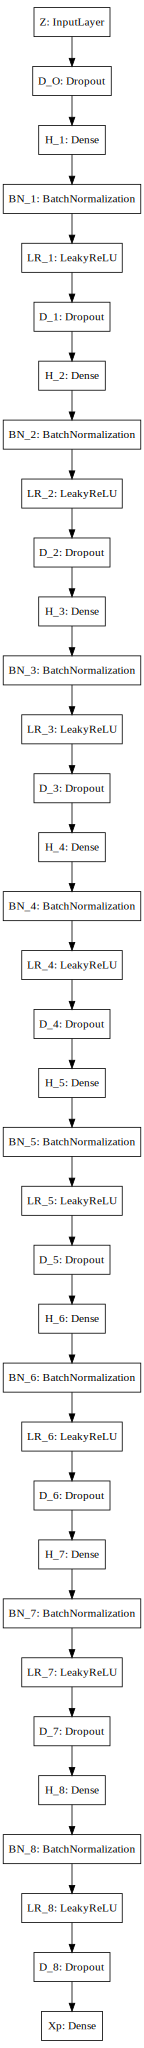

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


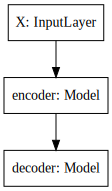

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))

### Train the model

In [12]:
loss, val_loss = model.train(val_split=0.2)

Start model training...
Train on 6000 samples, validate on 1500 samples
Epoch 1/500
6000/6000 [==============================] - 9s 1ms/step - loss: 2071.5390 - val_loss: 1990.2020
Epoch 2/500
6000/6000 [==============================] - 3s 545us/step - loss: 1898.6746 - val_loss: 1914.4948
Epoch 3/500
6000/6000 [==============================] - 3s 557us/step - loss: 1868.8675 - val_loss: 1887.2508
Epoch 4/500
6000/6000 [==============================] - 4s 584us/step - loss: 1855.5512 - val_loss: 1880.2084
Epoch 5/500
6000/6000 [==============================] - 3s 539us/step - loss: 1846.5887 - val_loss: 1871.7341
Epoch 6/500
6000/6000 [==============================] - 3s 495us/step - loss: 1839.4662 - val_loss: 1865.0992
Epoch 7/500
6000/6000 [==============================] - 3s 519us/step - loss: 1833.3860 - val_loss: 1862.7484
Epoch 8/500
6000/6000 [==============================] - 3s 506us/step - loss: 1828.1730 - val_loss: 1859.5809
Epoch 9/500
6000/6000 [===================

6000/6000 [==============================] - 3s 581us/step - loss: 1786.6819 - val_loss: 1830.4900
Epoch 74/500
6000/6000 [==============================] - 3s 541us/step - loss: 1786.3535 - val_loss: 1830.8048
Epoch 75/500
6000/6000 [==============================] - 3s 529us/step - loss: 1786.6888 - val_loss: 1830.5747
Epoch 76/500
6000/6000 [==============================] - 3s 542us/step - loss: 1786.2217 - val_loss: 1830.4845
Epoch 77/500
6000/6000 [==============================] - 3s 581us/step - loss: 1786.2964 - val_loss: 1830.6130
Epoch 78/500
6000/6000 [==============================] - 3s 540us/step - loss: 1786.0328 - val_loss: 1830.1206
Epoch 79/500
6000/6000 [==============================] - 3s 512us/step - loss: 1785.9916 - val_loss: 1830.4190
Epoch 80/500
6000/6000 [==============================] - 3s 515us/step - loss: 1785.8781 - val_loss: 1830.1333
Epoch 81/500
6000/6000 [==============================] - 3s 514us/step - loss: 1785.9809 - val_loss: 1830.2373
Epoch

Epoch 146/500
6000/6000 [==============================] - 3s 504us/step - loss: 1740.7767 - val_loss: 1776.7155
Epoch 147/500
6000/6000 [==============================] - 3s 496us/step - loss: 1739.4906 - val_loss: 1776.5550
Epoch 148/500
6000/6000 [==============================] - 3s 499us/step - loss: 1738.9433 - val_loss: 1776.3062
Epoch 149/500
6000/6000 [==============================] - 3s 518us/step - loss: 1739.4113 - val_loss: 1775.4597
Epoch 150/500
6000/6000 [==============================] - 3s 495us/step - loss: 1739.1072 - val_loss: 1777.3797
Epoch 151/500
6000/6000 [==============================] - 3s 529us/step - loss: 1739.9307 - val_loss: 1776.1431
Epoch 152/500
6000/6000 [==============================] - 3s 500us/step - loss: 1739.0900 - val_loss: 1775.7529
Epoch 153/500
6000/6000 [==============================] - 3s 507us/step - loss: 1739.1092 - val_loss: 1775.6625
Epoch 154/500
6000/6000 [==============================] - 3s 519us/step - loss: 1738.6499 - val

6000/6000 [==============================] - 3s 477us/step - loss: 1728.3955 - val_loss: 1762.1740
Epoch 219/500
6000/6000 [==============================] - 3s 465us/step - loss: 1725.9635 - val_loss: 1762.1481
Epoch 220/500
6000/6000 [==============================] - 3s 491us/step - loss: 1724.4099 - val_loss: 1756.5222
Epoch 221/500
6000/6000 [==============================] - 3s 488us/step - loss: 1723.6427 - val_loss: 1755.7864
Epoch 222/500
6000/6000 [==============================] - 3s 510us/step - loss: 1722.4888 - val_loss: 1761.7231
Epoch 223/500
6000/6000 [==============================] - 3s 473us/step - loss: 1722.4311 - val_loss: 1757.3397
Epoch 224/500
6000/6000 [==============================] - 3s 497us/step - loss: 1722.0013 - val_loss: 1754.1294
Epoch 225/500
6000/6000 [==============================] - 3s 492us/step - loss: 1720.8140 - val_loss: 1753.7980
Epoch 226/500
6000/6000 [==============================] - 3s 482us/step - loss: 1721.7995 - val_loss: 1754.23

6000/6000 [==============================] - 3s 507us/step - loss: 1706.4170 - val_loss: 1741.4256
Epoch 291/500
6000/6000 [==============================] - 3s 513us/step - loss: 1706.7578 - val_loss: 1739.5594
Epoch 292/500
6000/6000 [==============================] - 3s 554us/step - loss: 1706.7414 - val_loss: 1739.5376
Epoch 293/500
6000/6000 [==============================] - 3s 507us/step - loss: 1705.4302 - val_loss: 1740.3383
Epoch 294/500
6000/6000 [==============================] - 3s 513us/step - loss: 1707.6341 - val_loss: 1740.9356
Epoch 295/500
6000/6000 [==============================] - 3s 570us/step - loss: 1706.2383 - val_loss: 1740.0561
Epoch 296/500
6000/6000 [==============================] - 3s 542us/step - loss: 1707.6357 - val_loss: 1739.9075
Epoch 297/500
6000/6000 [==============================] - 3s 510us/step - loss: 1705.7750 - val_loss: 1739.6332
Epoch 298/500
6000/6000 [==============================] - 3s 521us/step - loss: 1706.2560 - val_loss: 1739.93

6000/6000 [==============================] - 3s 562us/step - loss: 1700.8642 - val_loss: 1737.3208
Epoch 363/500
6000/6000 [==============================] - 3s 570us/step - loss: 1700.2647 - val_loss: 1737.2686
Epoch 364/500
6000/6000 [==============================] - 3s 549us/step - loss: 1700.2355 - val_loss: 1737.7565
Epoch 365/500
6000/6000 [==============================] - 3s 546us/step - loss: 1700.7918 - val_loss: 1737.7832
Epoch 366/500
6000/6000 [==============================] - 3s 561us/step - loss: 1700.9806 - val_loss: 1738.1623
Epoch 367/500
6000/6000 [==============================] - 3s 543us/step - loss: 1700.0932 - val_loss: 1737.5697
Epoch 368/500
6000/6000 [==============================] - 3s 471us/step - loss: 1700.9052 - val_loss: 1737.3755
Epoch 369/500
6000/6000 [==============================] - 3s 511us/step - loss: 1699.6278 - val_loss: 1736.3458
Epoch 370/500
6000/6000 [==============================] - 3s 479us/step - loss: 1700.4756 - val_loss: 1737.39

6000/6000 [==============================] - 3s 493us/step - loss: 1698.9616 - val_loss: 1735.7162
Epoch 435/500
6000/6000 [==============================] - 3s 519us/step - loss: 1697.9341 - val_loss: 1735.3759
Epoch 436/500
6000/6000 [==============================] - 3s 510us/step - loss: 1697.8968 - val_loss: 1734.7016
Epoch 437/500
6000/6000 [==============================] - 3s 484us/step - loss: 1697.9365 - val_loss: 1735.7200
Epoch 438/500
6000/6000 [==============================] - 3s 502us/step - loss: 1696.7309 - val_loss: 1736.9249
Epoch 439/500
6000/6000 [==============================] - 3s 476us/step - loss: 1697.8830 - val_loss: 1736.3401
Epoch 440/500
6000/6000 [==============================] - 3s 477us/step - loss: 1697.0185 - val_loss: 1735.1399
Epoch 441/500
6000/6000 [==============================] - 3s 513us/step - loss: 1697.5087 - val_loss: 1735.7958
Epoch 442/500
6000/6000 [==============================] - 3s 519us/step - loss: 1696.7788 - val_loss: 1736.35

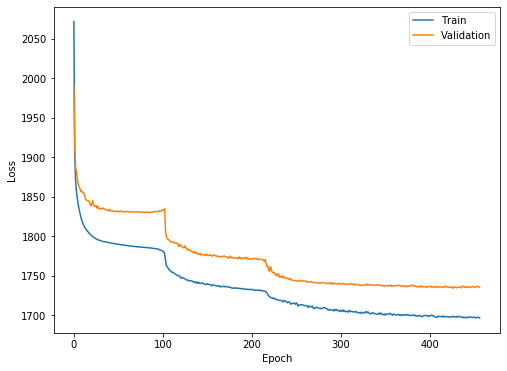

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
# save models in h5 format
os.makedirs('../models/VAE/PBMC10k', exist_ok=True)
model.export_model('../models/VAE/PBMC10k')

All networks exported in h5 format.


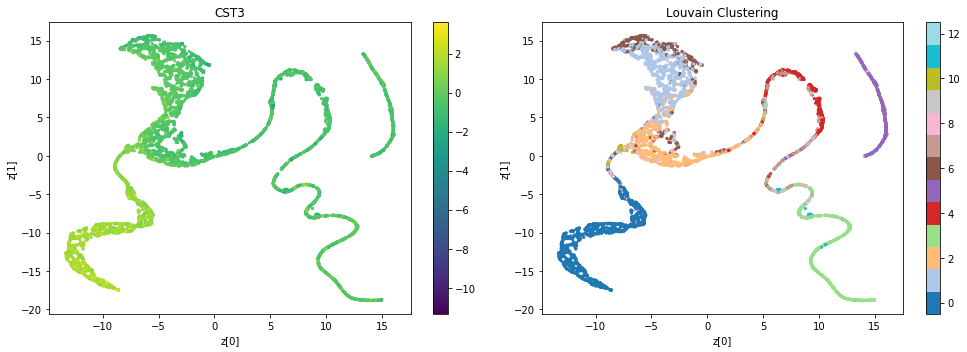

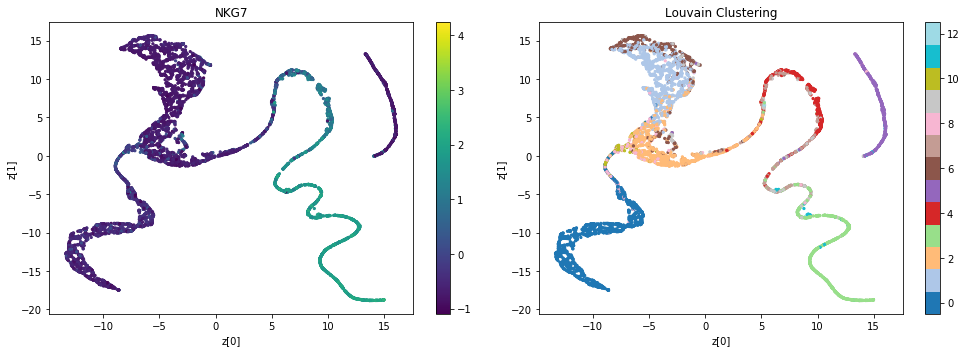

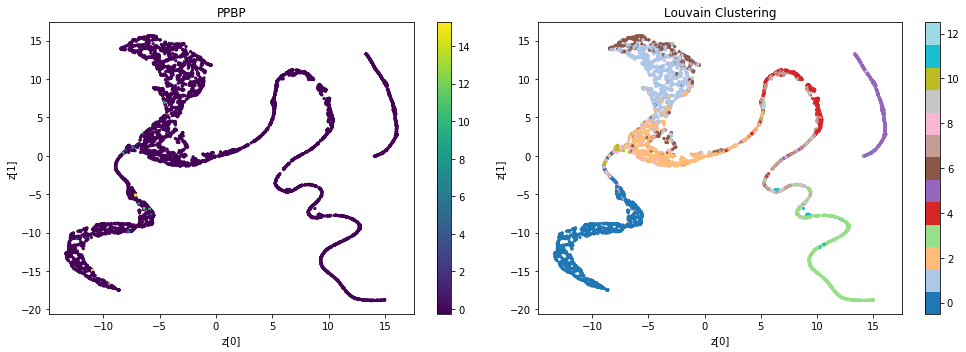

In [15]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis on 8k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Unsupervised Model

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC8k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC8k')

Model graphs saved.



### Visualize graphs


ENCODER


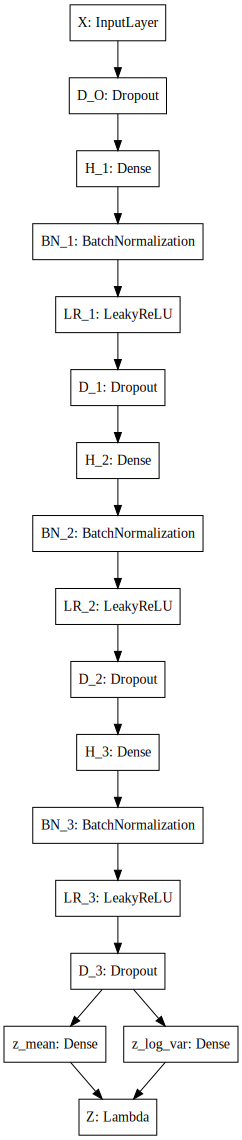

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


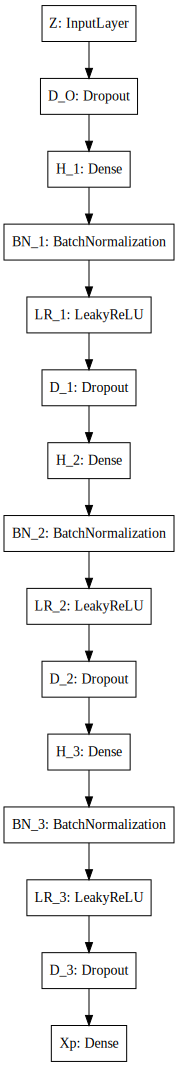

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


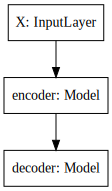

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


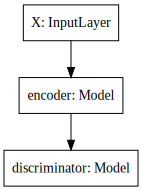

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


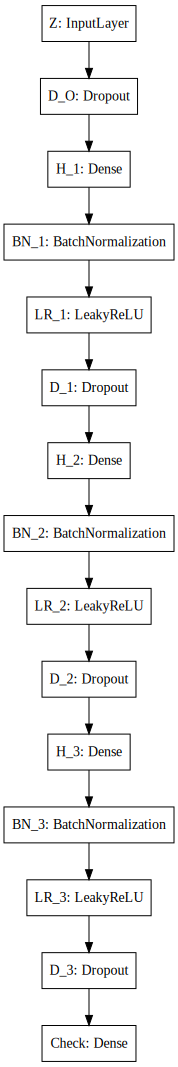

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.037190, generation loss: 0.409361, discriminator loss: 0.307326


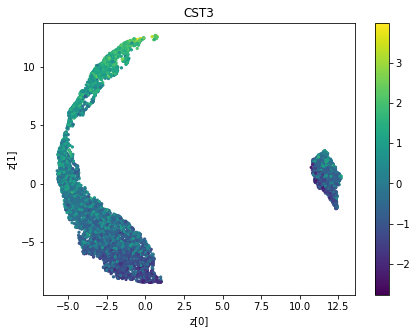

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC8k', exist_ok=True)
model.export_model('../models/AAE1/PBMC8k')

Adversarial Autoencoder networks exported in h5 format.


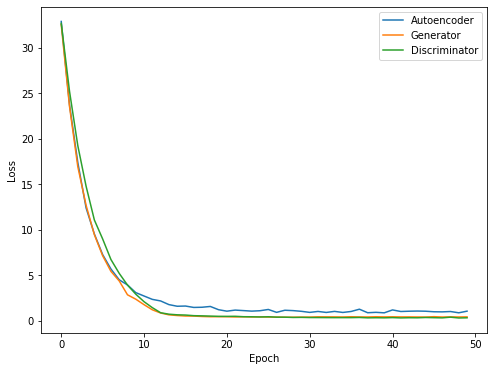

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

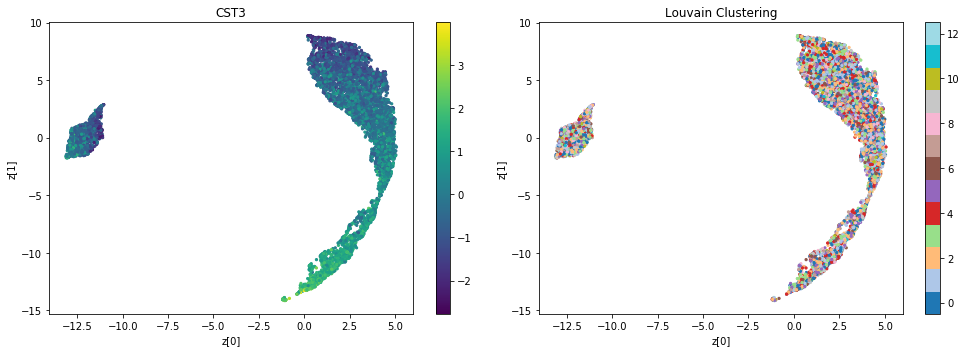

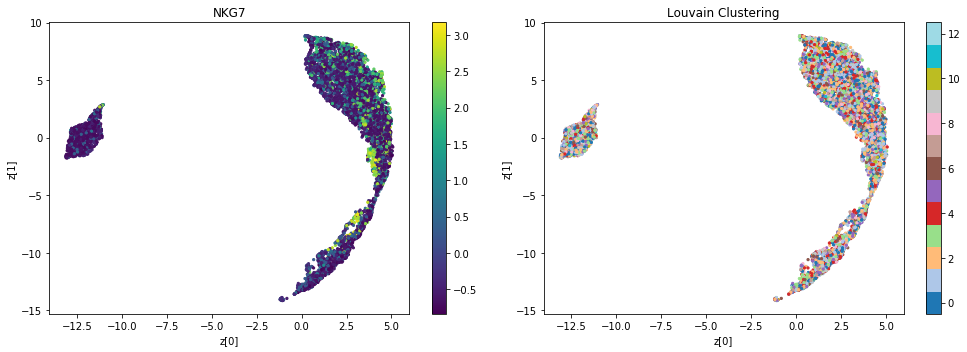

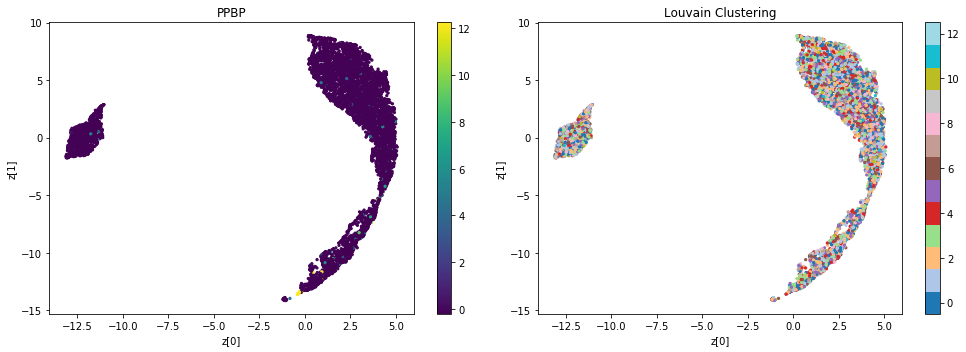

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC8k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC8k')

Model graphs saved.



### Visualize graphs


ENCODER


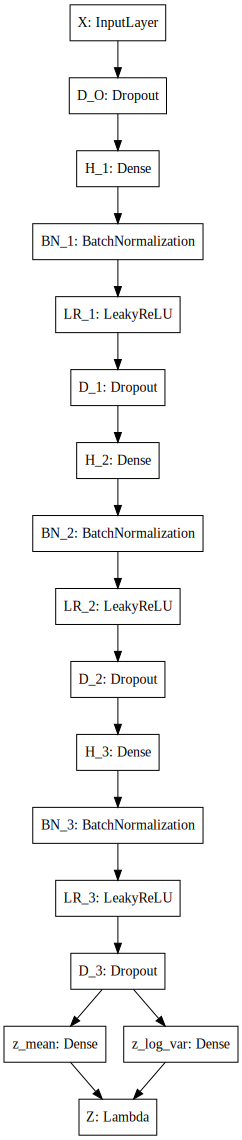

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


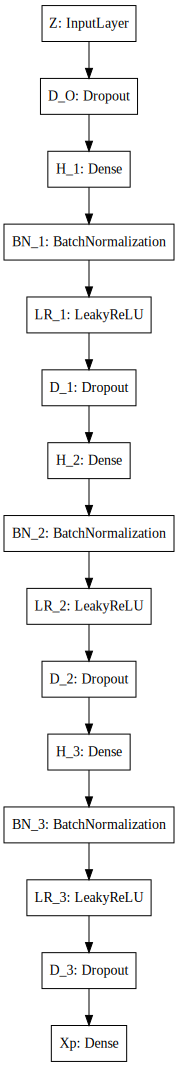

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


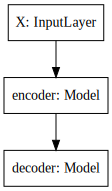

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


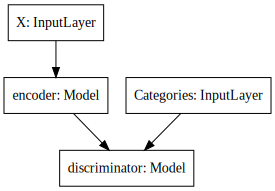

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


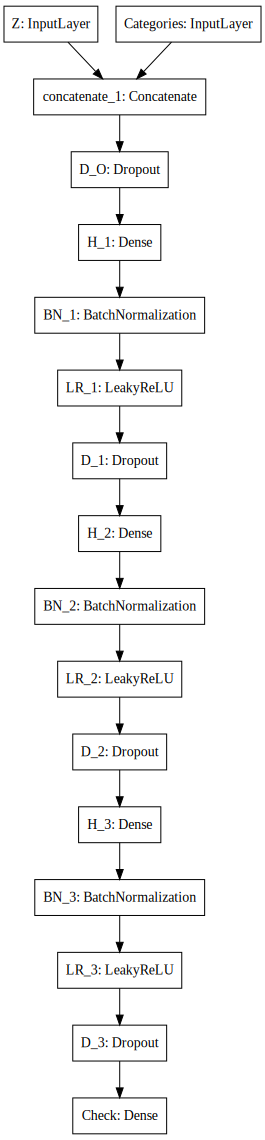

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.010608, generation loss: 0.410127, discriminator loss: 0.271828


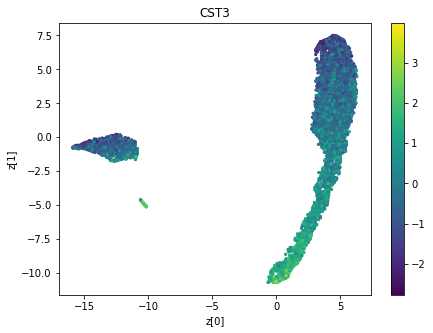

Training completed.


In [16]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC8k', exist_ok=True)
model.export_model('../models/AAE2/PBMC8k')

All networks exported in h5 format.


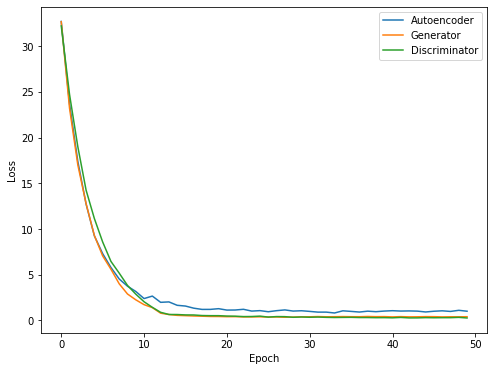

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

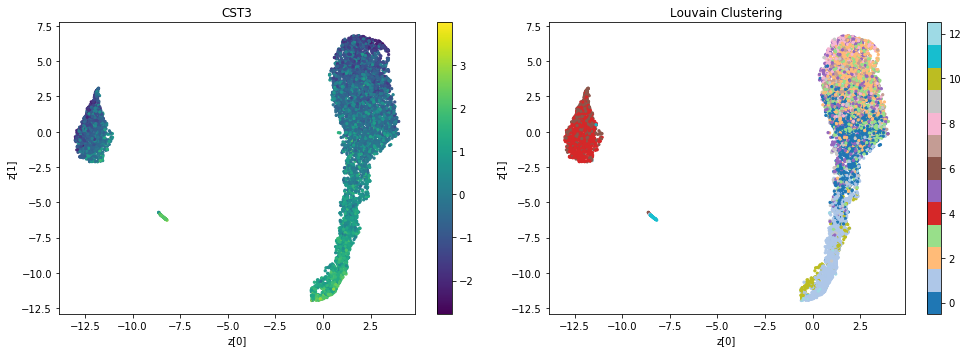

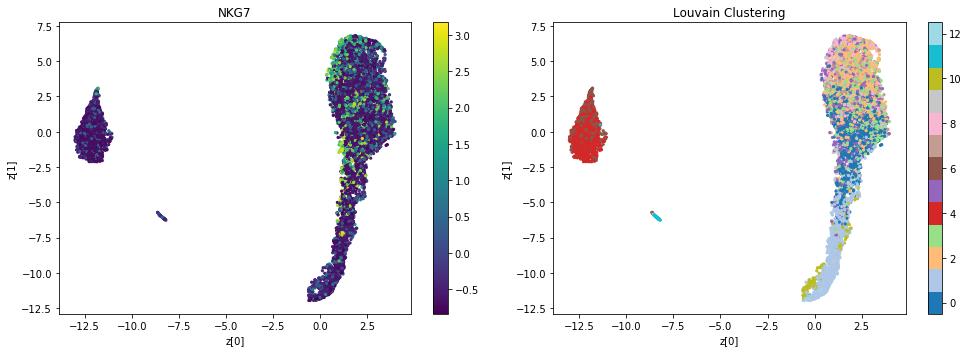

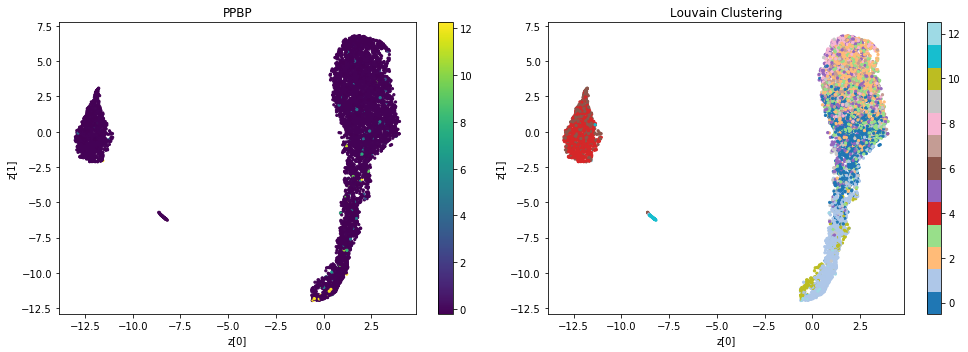

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis on 3k PBMC data


In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Unsupervised Model

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC3k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC3k')

Model graphs saved.



### Visualize graphs


ENCODER


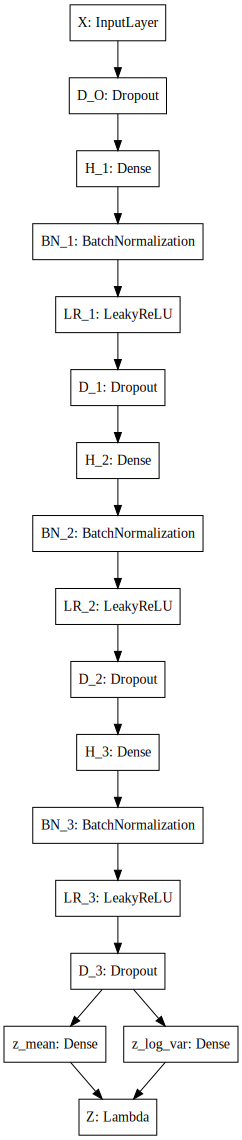

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


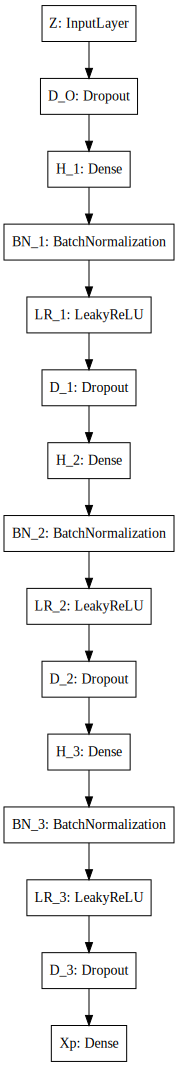

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


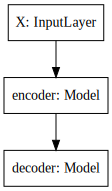

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


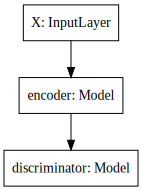

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


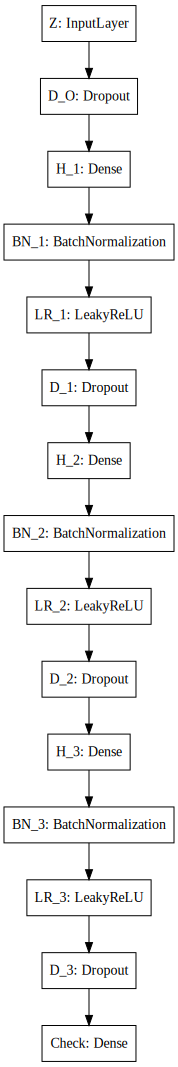

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.316368, generation loss: 0.451401, discriminator loss: 0.551019


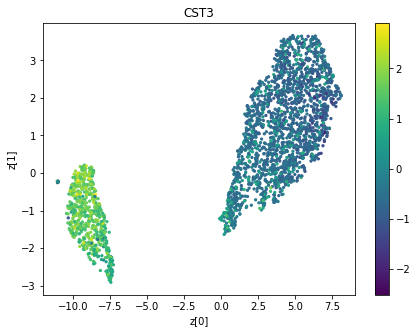

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC3k', exist_ok=True)
model.export_model('../models/AAE1/PBMC3k')

Adversarial Autoencoder networks exported in h5 format.


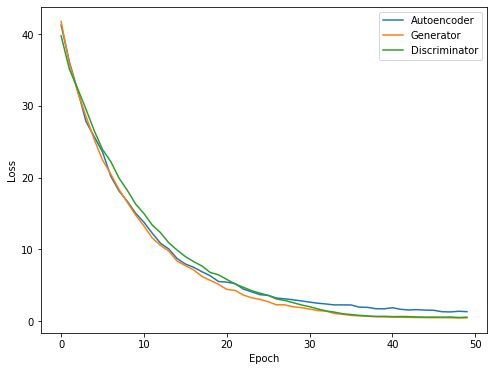

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

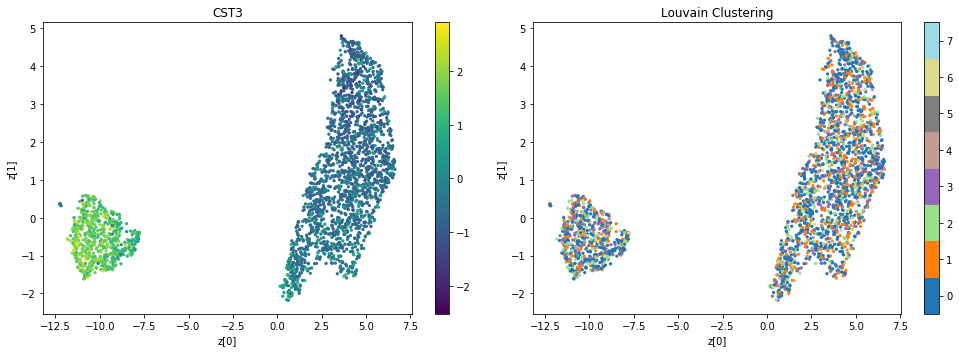

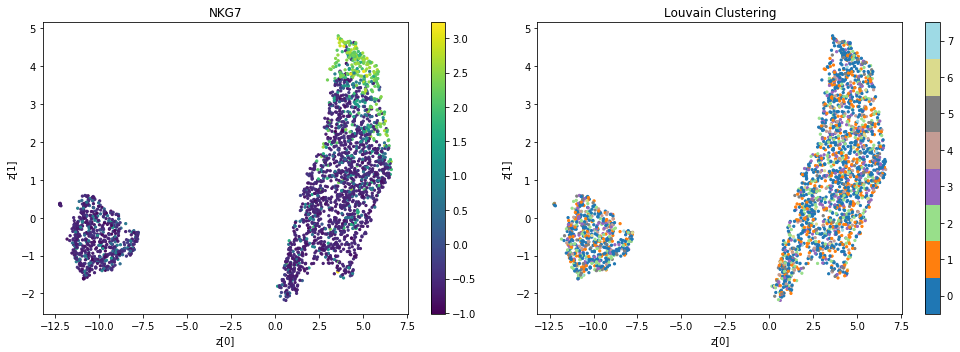

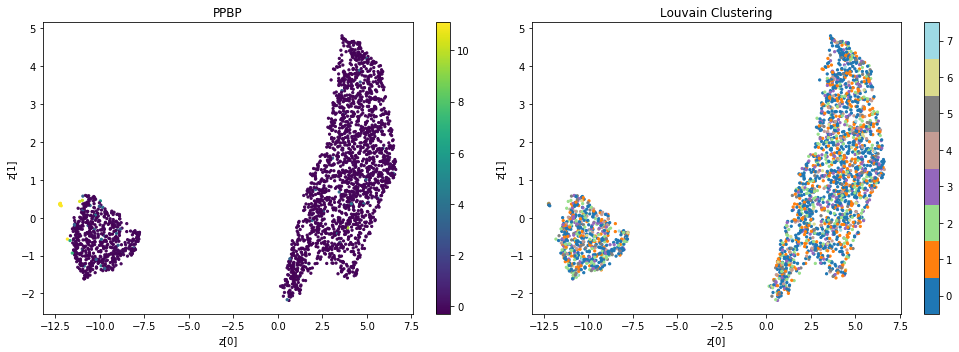

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC3k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC3k')

Model graphs saved.



### Visualize graphs


ENCODER


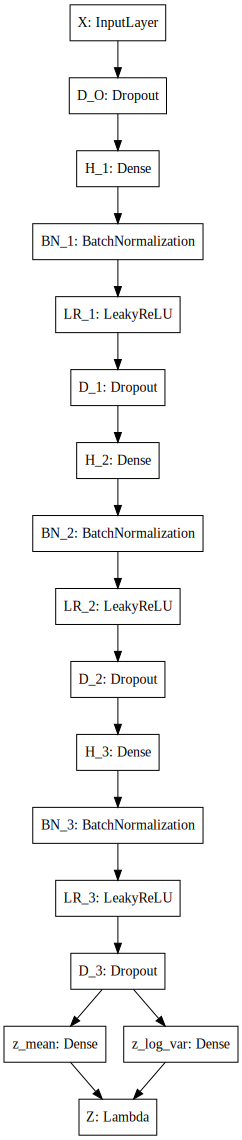

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


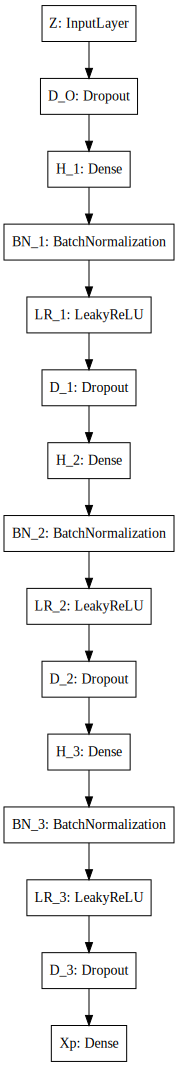

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


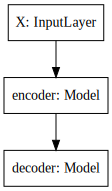

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


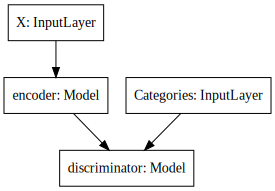

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


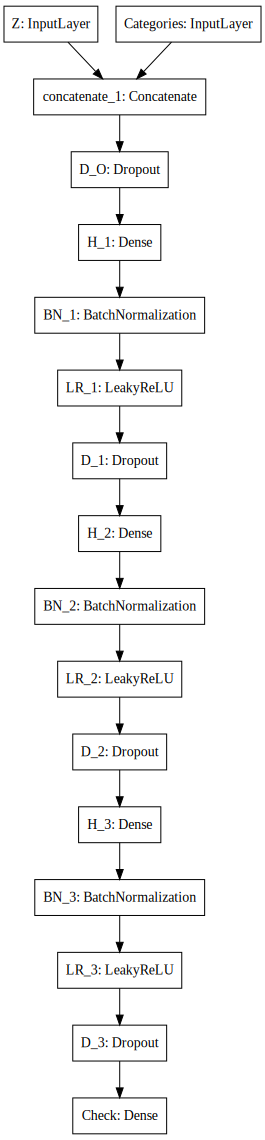

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.633830, generation loss: 0.489770, discriminator loss: 0.547568


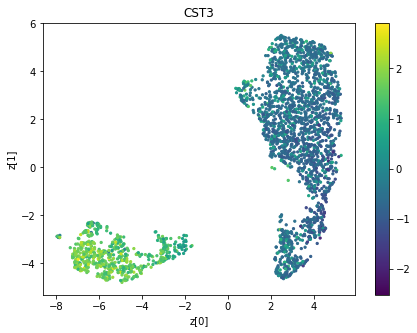

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC3k', exist_ok=True)
model.export_model('../models/AAE2/PBMC3k')

All networks exported in h5 format.


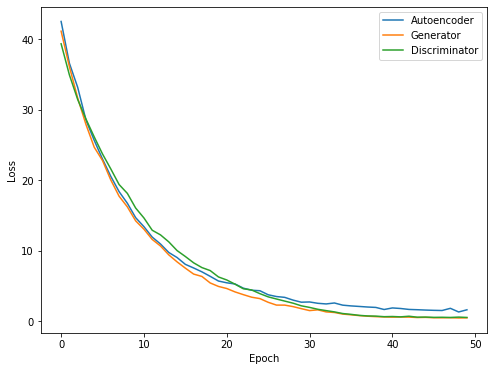

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

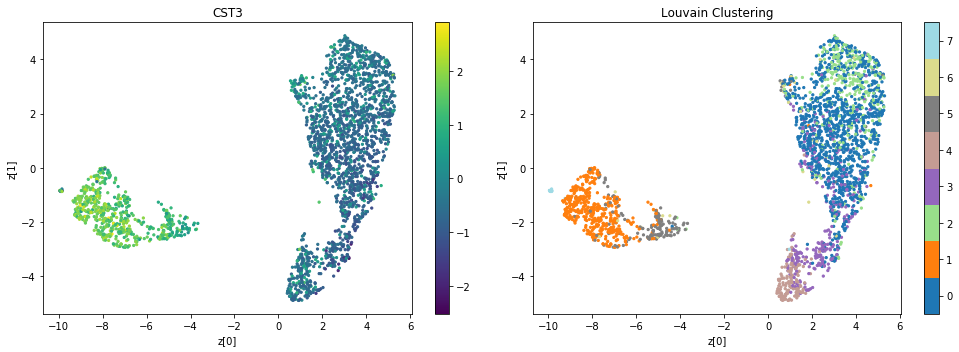

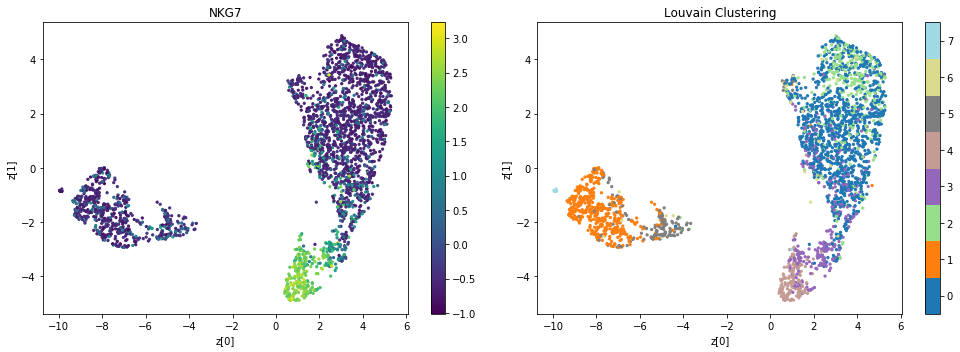

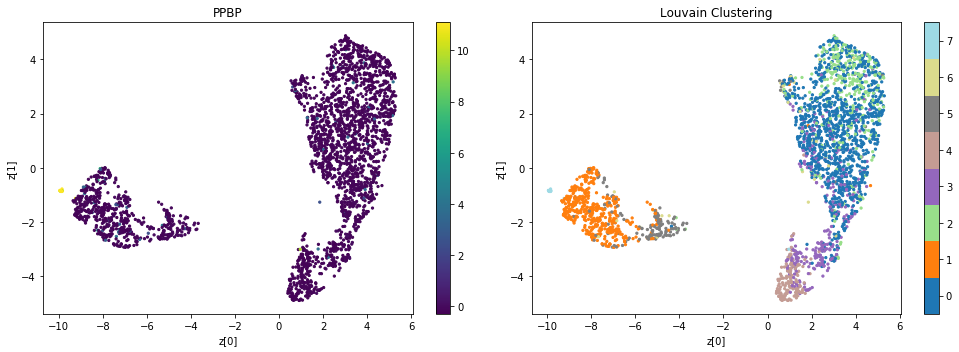

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)